In [1]:
versioninfo()

Julia Version 1.10.0
Commit 3120989f39 (2023-12-25 18:01 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 6 × Intel(R) Core(TM) i5-9600K CPU @ 3.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, skylake)
  Threads: 2 on 6 virtual cores
Environment:
  JULIA_PYTHONCALL_EXE = python


In [2]:
using PyPlot
using Printf

In [3]:
include("expm_de.jl")

function exp_de(λ::T, h, ϵ=eps()) where {T<:Number}
    if real(λ) < 0
        l, r = get_interval(h, ϵ, abs(1/λ))
    else
        l, r = Int(floor(-7 / h)), Int(floor(7 / h))
    end
    k = l:r
    x = om99_x.(k, h)
    dx = om99_dx.(k, h)
    sinx = om99_sinx.(k, h)
    return 2h * sum(@. dx * sinx * x / (x^2 + λ^2)) / π
end


h_inv_list = [5, 10, 20]
area_list = ["wide", "narrow"]
m = 101

results = []

for h_inv in h_inv_list
    h = 1 / h_inv
    for area in area_list
        if area == "wide"
            rmin, rmax = -5000, 0
            imin, imax = -2500, 2500
        else
            rmin, rmax = -30, 10
            imin, imax = -20, 20
        end
        R = LinRange(rmin, rmax, m)
        I = LinRange(imin, imax, m)
        Z = [r + i*im for i in Iterators.reverse(I), r in R]
        F = exp.(Z)
        X = exp_de.(Z, h)
        E = abs.(X - F)
        push!(results, Dict(
            "h_inv" => h_inv,
            "area" => area,
            "m" => m,
            "error" => vec(E)
        ))
    end
end

In [4]:
function log10_with_threshold(x)
    if x < 1e-16
        return -16
    elseif x > 1e1
        return 1
    else
        return log10(x)
    end
end

log10_with_threshold (generic function with 1 method)

In [5]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 6
rcParams["axes.titlesize"] = 6

6

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


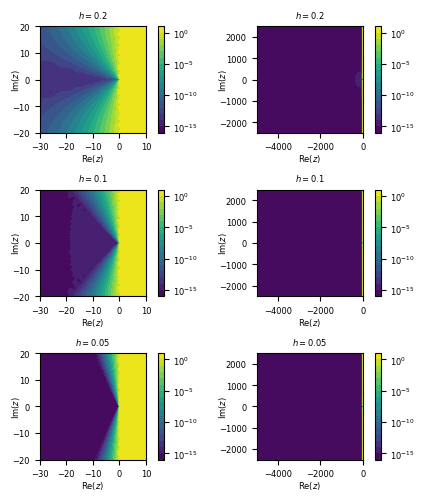

In [6]:
fig, ax = subplots(3, 2, figsize=[5,5])
h_inv_list = [5, 10, 20]
area_list = ["narrow", "wide"]
for (i, h_inv) in enumerate(h_inv_list)
    for (j, area) in enumerate(area_list)
        if area == "wide"
            rmin, rmax = -5000, 0
            imin, imax = -2500, 2500
        else
            rmin, rmax = -30, 10
            imin, imax = -20, 20
        end
        result = filter(d -> d["area"] == area && d["h_inv"] == h_inv, results)[1]
        m = result["m"]
        E = reshape(result["error"], m, m)
        p = ax[i,j].contourf(log10_with_threshold.(E), extent=[rmin,rmax,imin,imax], vmin=-16, vmax=1, levels=-16:1:1)
        cbar = fig.colorbar(p, ax=ax[i,j])
        cbar.set_ticks([-15, -10, -5, 0])
        cbar.set_ticklabels(["\$10^{-15}\$", "\$10^{-10}\$", "\$10^{-5}\$", "\$10^0\$"])
        ax[i,j].set_title("\$h = $(1/h_inv)\$")
        ax[i,j].set_xlabel("\$\\mathrm{Re}(z)\$", labelpad=0.5)
        ax[i,j].set_ylabel("\$\\mathrm{Im}(z)\$", labelpad=-7)
        ax[i,j].set_aspect(1)
    end
end
fig.tight_layout(h_pad=1, w_pad=-7)
fig.savefig("fig/test1.pdf", pad_inches=0)
show()
